In [36]:
import json, gzip
import random as rnd
import numpy as np
import sys
import time
from IPython.display import display, HTML
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [38]:
fileName = '<dictionary_file_name>'
reader = open(fileName, 'rU')
vocabulary = {}
counter = 0
for line in reader:
    vocabulary[int(line.strip())] = counter 
    counter = counter + 1
reader.close()

In [39]:
documents = []
document = []
fileName = '<documents_file_name>'
reader = open(fileName, 'rU')
ldocid = -1l
for line in reader:
    tokens = line.strip().split(',')
    docid = int(tokens[0])
    word = int(tokens[1])
    wordIndex = vocabulary[word]
    if ldocid != -1l and docid != ldocid:
        documents.append(document)
        doc = []
    doc.append(wordIndex)
    ldocid = docid
documents.append(doc)
reader.close()

In [40]:
len(vocabulary),len(documents)

(5250, 100000)

# Expectation Maximization

In [15]:
class MultinomialMixture :
    def __init__(self, num_clusters, vocabulary_size):
        self.multinomials = np.zeros((vocabulary_size, num_clusters))
        self.proportions = np.zeros(num_clusters)
        self.num_clusters = num_clusters
        self.vocabulary_size = vocabulary_size
        for w in range(vocabulary_size):
            for k in range(num_clusters):
                self.multinomials[w, k] = rnd.uniform(0,1)
        
        for k in range(num_clusters):
            self.multinomials[:, k] /= self.multinomials[:, k].sum()
            self.proportions[k]  = rnd.uniform(0, 1)
        self.proportions /= self.proportions.sum()
        
    def compute_multinomial_responsibilities(self, doc):
        
        q_zn = np.zeros(self.num_clusters)
        q_zn += self.proportions
        
        for v in doc:
            q_zn *= self.multinomials[v, :]
            q_zn /= max(q_zn)
        
        return q_zn / q_zn.sum()
    
    def compute_multinomial_responsibilities_with_lb(self, doc):
        
        q_zn = np.zeros(self.num_clusters)
        q_zn += self.proportions
        log_cumulative_scale = 0
        for v in doc:
            q_zn *= self.multinomials[v, :]
            scale =  max(q_zn)
            log_cumulative_scale += log(scale)
            q_zn /= scale
        
        normalizer = q_zn.sum()
        return (q_zn / normalizer, log(normalizer) + log_cumulative_scale)
        
    def compute_lower_bound(self, q_zn, doc):
        valid_ind = q_zn > 0
        entropy = q_zn[valid_ind].dot(q_zn[valid_ind])
        comp1 = q_zn.dot(log(self.proportions))
        comp2 = 0
        for v in doc:
            likelihood_v = self.multinomials[v, :]
            valid_ind = likelihood_v > 0
            comp2 += q_zn[valid_ind].dot(log(likelihood_v[valid_ind]))
    
        return comp1 + comp2 - entropy
    
    def fit(self, documents, max_iter):
        aggregates = np.zeros((self.vocabulary_size, self.num_clusters))
        prop_aggregates = np.zeros(self.num_clusters)
        lower_bounds = []
        q_zn = np.zeros(self.num_clusters)
        for iteration in range(max_iter):
            lower_bound = 0
            start = time.time()
            for doc in documents:
                q_zn, lb = self.compute_multinomial_responsibilities_with_lb(doc)
                lower_bound += lb
                aggregates[doc, :] += q_zn
                prop_aggregates += q_zn
            
            self.proportions = prop_aggregates / prop_aggregates.sum()
            for k in range(self.num_clusters):
                self.multinomials[:, k] = aggregates[:, k] / (aggregates[:, k].sum())
            aggregates *= 0
            prop_aggregates *= 0
            lower_bounds.append(lower_bound)
            end = time.time()
            duration = end - start
            print 'iter:%d,lower_bound:%f,duration:%f secs'%(iteration, lower_bound,duration)
            sys.stdout.flush()
        return lower_bounds

In [36]:
num_clusters = 100
multinomial_mixture_model = MultinomialMixture(num_clusters, len(vocabulary))
lower_bounds = []

In [ ]:
lower_bounds_1 = multinomial_mixture_model.fit(documents, 100)

In [19]:
lower_bounds_2 = multinomial_mixture_model.fit(documents, 50)

iter:0,lower_bound:-34550925.735975,duration:85.082673 secs
iter:1,lower_bound:-34550615.967011,duration:84.855282 secs
iter:2,lower_bound:-34550318.418235,duration:85.159552 secs
iter:3,lower_bound:-34550043.398711,duration:85.443403 secs
iter:4,lower_bound:-34549810.265726,duration:85.007944 secs
iter:5,lower_bound:-34549515.501112,duration:84.793148 secs
iter:6,lower_bound:-34549295.727313,duration:84.945006 secs
iter:7,lower_bound:-34549074.747334,duration:88.487706 secs
iter:8,lower_bound:-34548929.190622,duration:107.211903 secs
iter:9,lower_bound:-34548707.507324,duration:104.724047 secs
iter:10,lower_bound:-34548574.068746,duration:94.439614 secs
iter:11,lower_bound:-34548441.187247,duration:85.012167 secs
iter:12,lower_bound:-34548312.345733,duration:85.022323 secs
iter:13,lower_bound:-34548163.888608,duration:85.250630 secs
iter:14,lower_bound:-34548041.801027,duration:84.922757 secs
iter:15,lower_bound:-34547902.990646,duration:85.022633 secs
iter:16,lower_bound:-34547756.81

In [20]:
for l in lower_bounds_1:
    lower_bounds.append(l)

for l in lower_bounds_2:
    lower_bounds.append(l)


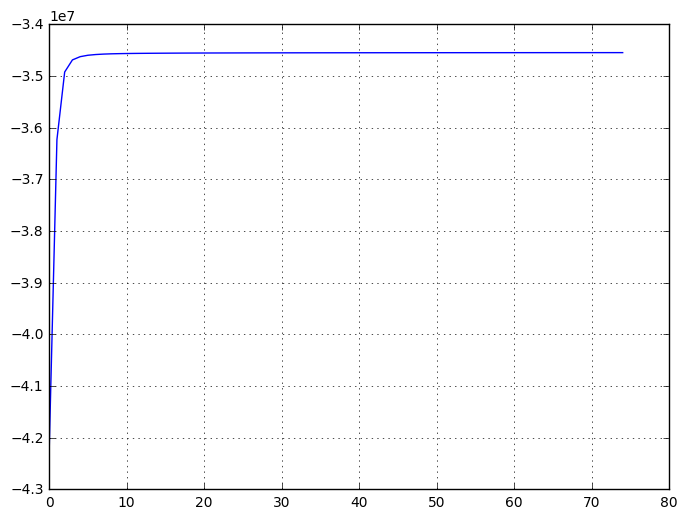

In [35]:
f = subplots(1,1, figsize = (8, 6))
f[1].plot(lower_bounds);
f[1].grid()

# Collapsed Gibbs Sampler

In [11]:
class DocumentWithCluster:
    def __init__(self, doc):
        self.doc = doc
        self.topic_index = 0

document_with_cluster_list = [DocumentWithCluster(doc) for doc in documents]

In [12]:
class CollapsedGibbsSampler:
    def __init__(self, num_clusters, vocabulary_size, mixing_proportions_prior, topic_prior):
        self.num_clusters = num_clusters
        self.vocabulary_size = vocabulary_size
        self.mixing_proportions_prior = mixing_proportions_prior
        self.topic_prior = topic_prior
        self.wordCountByWordAndFactor = np.zeros((vocabulary_size, num_clusters), dtype=np.int32)
        self.wordCountByFactor = np.zeros(num_clusters, dtype=np.int32)
        self.documentCountByFactor = np.zeros(num_clusters, dtype=np.int32)
        self.training_lik = 0
        self.complete_conditional = np.zeros(num_clusters)
        self.vb = topic_prior * vocabulary_size
        
    def initialize(self, document_with_cluster_list):
        for document_with_cluster in document_with_cluster_list:
            document_with_cluster.topic_index = np.random.choice(self.num_clusters, 1)[0]
            
            self.wordCountByWordAndFactor[document_with_cluster.doc, document_with_cluster.topic_index] += 1
            self.wordCountByFactor[document_with_cluster.topic_index] += len(document_with_cluster.doc)
            self.documentCountByFactor[document_with_cluster.topic_index] += 1
            
    def sample_from_complete_conditional_for_topic_for_doc(self, doc):
        ll = np.ones(self.num_clusters)
        cumulative_log_scale = 0
        for v in doc:
            ll *= (self.wordCountByWordAndFactor[v, :] + self.topic_prior) / (self.wordCountByFactor + self.vb)
            scale = max(ll)
            cumulative_log_scale += np.log(scale)
            ll /= scale
            
        self.complete_conditional = ll * (self.documentCountByFactor + self.mixing_proportions_prior)
        normalizer = self.complete_conditional.sum()
        self.complete_conditional /= normalizer
        topic_index = np.random.choice(self.num_clusters, 1, replace = False, p = self.complete_conditional)[0]
        self.training_lik += np.log(normalizer) + cumulative_log_scale
        return topic_index
    
    def run_sampler(self, document_with_cluster_list, max_iterations):
        for iteration in np.arange(max_iterations):
            self.training_lik = 0
            total_obs = 0
            start = time.time()

            for document_with_cluster in document_with_cluster_list:
                
                self.wordCountByWordAndFactor[document_with_cluster.doc, document_with_cluster.topic_index] -= 1
                self.wordCountByFactor[document_with_cluster.topic_index] -= len(document_with_cluster.doc)
                self.documentCountByFactor[document_with_cluster.topic_index] -= 1
                
                document_with_cluster.topic_index = self.sample_from_complete_conditional_for_topic_for_doc(document_with_cluster.doc)
                
                self.wordCountByWordAndFactor[document_with_cluster.doc, document_with_cluster.topic_index] += 1
                self.wordCountByFactor[document_with_cluster.topic_index] += len(document_with_cluster.doc)
                self.documentCountByFactor[document_with_cluster.topic_index] += 1
                
                total_obs += len(document_with_cluster.doc)
            
            end = time.time()
            duration = end - start
            print 'iter:%s,trainingLL:%.4f,duration:%.4f secs' % (iteration, self.training_lik / total_obs, duration)
            sys.stdout.flush()

In [14]:
gibbs_sampler = CollapsedGibbsSampler(num_clusters=100,
                                      vocabulary_size=len(vocabulary),
                                      mixing_proportions_prior = 0.01,
                                      topic_prior = 0.01)
gibbs_sampler.initialize(document_with_cluster_list=document_with_cluster_list)

In [15]:
gibbs_sampler.run_sampler(document_with_cluster_list = document_with_cluster_list, max_iterations = 100)

iter:0,trainingLL:-7.1174,duration:119.3286 secs
iter:1,trainingLL:-7.0044,duration:119.8174 secs
iter:2,trainingLL:-6.9788,duration:120.0058 secs
iter:3,trainingLL:-6.9668,duration:120.1556 secs
iter:4,trainingLL:-6.9602,duration:120.1897 secs
iter:5,trainingLL:-6.9554,duration:119.9911 secs
iter:6,trainingLL:-6.9524,duration:120.0445 secs
iter:7,trainingLL:-6.9505,duration:120.5137 secs
iter:8,trainingLL:-6.9494,duration:120.7709 secs
iter:9,trainingLL:-6.9488,duration:120.3573 secs
iter:10,trainingLL:-6.9483,duration:120.4899 secs
iter:11,trainingLL:-6.9479,duration:120.6922 secs
iter:12,trainingLL:-6.9476,duration:120.4757 secs
iter:13,trainingLL:-6.9473,duration:120.4348 secs
iter:14,trainingLL:-6.9471,duration:120.9466 secs
iter:15,trainingLL:-6.9469,duration:121.0840 secs
iter:16,trainingLL:-6.9467,duration:120.9786 secs
iter:17,trainingLL:-6.9467,duration:120.7265 secs
iter:18,trainingLL:-6.9466,duration:120.6130 secs
iter:19,trainingLL:-6.9465,duration:120.7785 secs
iter:20,tr

# Stochastic Variational Inference

In [41]:
from scipy.special import psi as digamma

In [116]:
class StochasticVariationalInference :
    def __init__(self, num_documents, num_clusters, vocabulary_size, mini_batch_size, h_beta, h_theta):
        avg_words_per_doc = 50.
        self.v_beta_agg = np.random.exponential(num_documents * avg_words_per_doc / (vocabulary_size * num_clusters), (vocabulary_size, num_clusters))
        self.v_theta_agg = np.random.exponential(num_documents * 1.0 / num_clusters, num_clusters)

        self.v_beta_exp = digamma(self.v_beta_agg + h_beta)
        self.v_theta_exp = digamma(self.v_theta_agg + h_theta) - digamma((self.v_theta_agg + h_theta).sum())
        temp = digamma((self.v_beta_agg + h_beta).sum(0))
        for w in np.arange(vocabulary_size):
            self.v_beta_exp[w, :] -= temp


        self.num_clusters = num_clusters
        self.vocabulary_size = vocabulary_size
        self.mini_batch_size = mini_batch_size
        self.h_theta = h_theta
        self.h_beta = h_beta
        self.training_ll = 0

    def compute_multinomial_responsibilities(self, doc):

        q_zn = np.zeros(self.num_clusters)
        q_zn += self.v_theta_exp

        for v in doc:
            q_zn += self.v_beta_exp[v, :]
        cumulative_log_scale = max(q_zn)
        q_zn -= cumulative_log_scale
        q_zn = np.exp(q_zn)
        normalizer = q_zn.sum()
        self.training_ll += cumulative_log_scale + np.log(normalizer)
        return q_zn / normalizer

    def fit(self, documents, max_iter):
        beta_aggregates = np.zeros((self.vocabulary_size, self.num_clusters))
        theta_aggregates = np.zeros(self.num_clusters)
        forgetting_rate = 0.7
        delay = 2
        for iteration in range(max_iter):
            learning_rate_t = np.power((iteration + delay), -1 * forgetting_rate)
            self.training_ll = 0
            beta_aggregates *= 0
            theta_aggregates *= 0
            start = time.time()
            total_obs = 0
            mini_batch_indices = rnd.sample(np.arange(len(documents)), self.mini_batch_size)
            for ind in mini_batch_indices:
                doc = documents[ind]
                q_zn = self.compute_multinomial_responsibilities(doc)
                beta_aggregates[doc, :] += q_zn
                theta_aggregates += q_zn
                total_obs += len(doc)

            ll_thickening_factor = len(documents) * 1.0 / len(mini_batch_indices)
            
            self.v_beta_agg = (1 - learning_rate_t) * self.v_beta_agg + learning_rate_t * ll_thickening_factor * beta_aggregates
            self.v_beta_exp = digamma(self.v_beta_agg + self.h_beta)
            temp = digamma((self.v_beta_agg + self.h_beta).sum(0))
            for w in np.arange(self.vocabulary_size):
                self.v_beta_exp[w, :] -= temp

            self.v_theta_agg = (1 - learning_rate_t) * self.v_theta_agg + learning_rate_t * ll_thickening_factor * theta_aggregates + self.h_theta
            self.v_theta_exp = digamma(self.v_theta_agg + self.h_theta) - digamma((self.v_theta_agg + self.h_theta).sum())

            end = time.time()
            duration = end - start
            print 'iter:%d,training_ll:%f,learning_rate:%f,duration:%f secs'%(iteration, self.training_ll / total_obs,learning_rate_t,duration)
            sys.stdout.flush()
        return

In [117]:
svi = StochasticVariationalInference(num_documents = len(documents),
                                     num_clusters = 100,
                                     vocabulary_size = len(vocabulary),
                                     mini_batch_size = 5000,
                                     h_beta = 0.01,
                                     h_theta = 0.01)

In [118]:
svi.fit(documents, 300)

iter:0,training_ll:-9.033846,learning_rate:0.615572,duration:1.859016 secs
iter:1,training_ll:-7.835030,learning_rate:0.463463,duration:2.220320 secs
iter:2,training_ll:-7.525486,learning_rate:0.378929,duration:2.331630 secs
iter:3,training_ll:-7.421320,learning_rate:0.324131,duration:2.181140 secs
iter:4,training_ll:-7.381935,learning_rate:0.285295,duration:1.919822 secs
iter:5,training_ll:-7.357037,learning_rate:0.256113,duration:1.834947 secs
iter:6,training_ll:-7.355625,learning_rate:0.233258,duration:1.712588 secs
iter:7,training_ll:-7.343074,learning_rate:0.214798,duration:1.577381 secs
iter:8,training_ll:-7.346145,learning_rate:0.199526,duration:1.370758 secs
iter:9,training_ll:-7.329162,learning_rate:0.186649,duration:1.208718 secs
iter:10,training_ll:-7.321702,learning_rate:0.175620,duration:1.145792 secs
iter:11,training_ll:-7.302745,learning_rate:0.166050,duration:1.078139 secs
iter:12,training_ll:-7.307825,learning_rate:0.157656,duration:1.032471 secs
iter:13,training_ll:-7